# Results plotting

Change file_path below to the .pkl saved by main.py and run all cells. The notebook will inspect which keys exist and plot available diagnostics (losses, calibration, sharpness, ECE, group cali scores, scoring rules).

In [2]:
# Imports and load results
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import warnings

# Set this to the .pkl file produced by main.py
file_path = "boston_lossscaled_batch_cal_ens1_bootFalse_seed0.pkl"

with open(file_path, "rb") as f:
    results = pickle.load(f)

print("Loaded keys:", sorted(list(results.keys())))

Loaded keys: ['best_model_metrics', 'recal_best_metrics', 'recal_exp_props', 'recal_final_metrics', 'recal_model', 'recal_te_bag_nll', 'recal_te_bag_nll_best', 'recal_te_cali_score', 'recal_te_cali_score_best', 'recal_te_crps', 'recal_te_crps_best', 'recal_te_g_cali_scores', 'recal_te_g_cali_scores_best', 'recal_te_interval', 'recal_te_interval_best', 'recal_te_mpiw', 'recal_te_mpiw_best', 'recal_te_obs_props', 'recal_te_obs_props_best', 'recal_te_q_preds', 'recal_te_q_preds_best', 'recal_te_scoring_rules', 'recal_te_scoring_rules_best', 'recal_te_sharp_score', 'recal_te_sharp_score_best', 'recal_va_bag_nll', 'recal_va_bag_nll_best', 'recal_va_cali_score', 'recal_va_cali_score_best', 'recal_va_crps', 'recal_va_crps_best', 'recal_va_g_cali_scores', 'recal_va_g_cali_scores_best', 'recal_va_interval', 'recal_va_interval_best', 'recal_va_mpiw', 'recal_va_mpiw_best', 'recal_va_obs_props', 'recal_va_obs_props_best', 'recal_va_q_preds', 'recal_va_q_preds_best', 'recal_va_scoring_rules', 'reca

In [3]:
# Quick summary helper
def maybe_get(key, default=None):
    return results.get(key, default)

def to_np(x):
    if x is None:
        return None
    if isinstance(x, list):
        try:
            return np.array(x)
        except Exception:
            return np.array([np.array(i) for i in x])
    if isinstance(x, torch.Tensor):
        return x.cpu().numpy()
    return np.array(x)

for key in [
    'tr_loss_list','va_loss_list','te_loss_list','va_sharp_list','va_ece_list',
    'va_exp_props','va_obs_props','va_q_preds','te_exp_props','te_obs_props','te_q_preds',
    'te_g_cali_scores','te_scoring_rules', 'va_bag_nll_list','va_crps_list','va_mpiw_list','va_interval_list'
]:
    if key in results:
        val = results[key]
        try:
            l = len(val)
        except Exception:
            l = None
        print(f"{key}: type={type(val)}, len_example={l}")
    else:
        print(f"{key}: MISSING")

tr_loss_list: type=<class 'list'>, len_example=30
va_loss_list: type=<class 'list'>, len_example=30
te_loss_list: type=<class 'list'>, len_example=30
va_sharp_list: type=<class 'list'>, len_example=30
va_ece_list: type=<class 'list'>, len_example=30
va_exp_props: type=<class 'torch.Tensor'>, len_example=501
va_obs_props: type=<class 'torch.Tensor'>, len_example=501
va_q_preds: type=<class 'torch.Tensor'>, len_example=91
te_exp_props: type=<class 'torch.Tensor'>, len_example=99
te_obs_props: type=<class 'torch.Tensor'>, len_example=99
te_q_preds: type=<class 'torch.Tensor'>, len_example=51
te_g_cali_scores: type=<class 'numpy.ndarray'>, len_example=10
te_scoring_rules: type=<class 'dict'>, len_example=5
va_bag_nll_list: type=<class 'list'>, len_example=30
va_crps_list: type=<class 'list'>, len_example=30
va_mpiw_list: type=<class 'list'>, len_example=30
va_interval_list: type=<class 'list'>, len_example=30


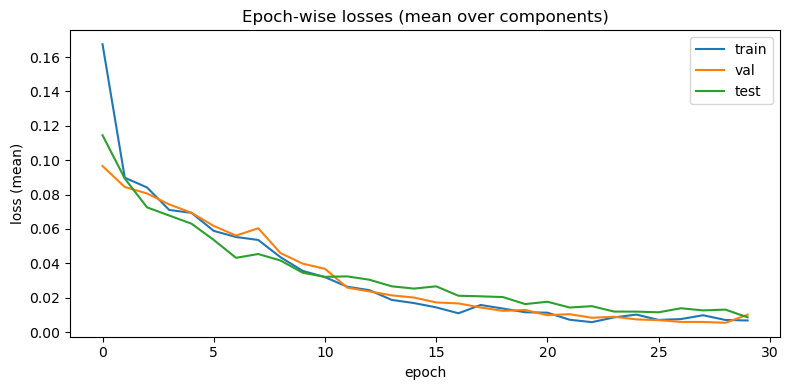

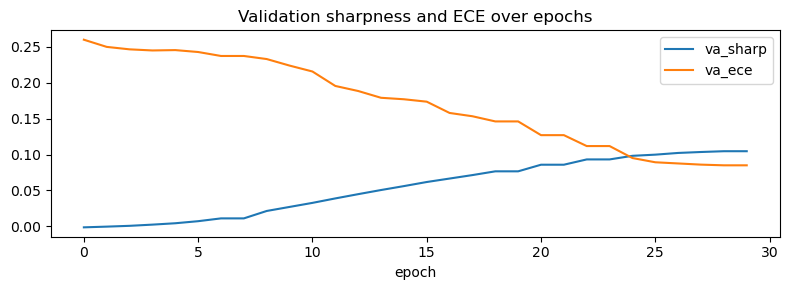

In [4]:
# Plot epoch-wise losses and optional validation diagnostics
tr = to_np(maybe_get('tr_loss_list'))
va = to_np(maybe_get('va_loss_list'))
te = to_np(maybe_get('te_loss_list'))

plt.figure(figsize=(8,4))
if tr is not None:
    # tr may be array of vectors per epoch; try to reduce to scalar if needed
    try:
        tr_mean = np.array([np.mean(x) for x in tr])
    except Exception:
        tr_mean = np.array(tr)
    plt.plot(tr_mean, label='train')
if va is not None:
    try:
        va_mean = np.array([np.mean(x) for x in va])
    except Exception:
        va_mean = np.array(va)
    plt.plot(va_mean, label='val')
if te is not None:
    try:
        te_mean = np.array([np.mean(x) for x in te])
    except Exception:
        te_mean = np.array(te)
    plt.plot(te_mean, label='test')
plt.xlabel('epoch')
plt.ylabel('loss (mean)')
plt.legend()
plt.title('Epoch-wise losses (mean over components)')
plt.tight_layout()
plt.show()

# Plot va_sharp_list and va_ece_list if present
va_sharp = to_np(maybe_get('va_sharp_list'))
va_ece = to_np(maybe_get('va_ece_list'))
if va_sharp is not None or va_ece is not None:
    plt.figure(figsize=(8,3))
    if va_sharp is not None:
        plt.plot(va_sharp, label='va_sharp')
    if va_ece is not None:
        plt.plot(va_ece, label='va_ece')
    plt.xlabel('epoch')
    plt.legend()
    plt.title('Validation sharpness and ECE over epochs')
    plt.tight_layout()
    plt.show()
else:
    print("Training log of validation sharpness and ECE is not available.")

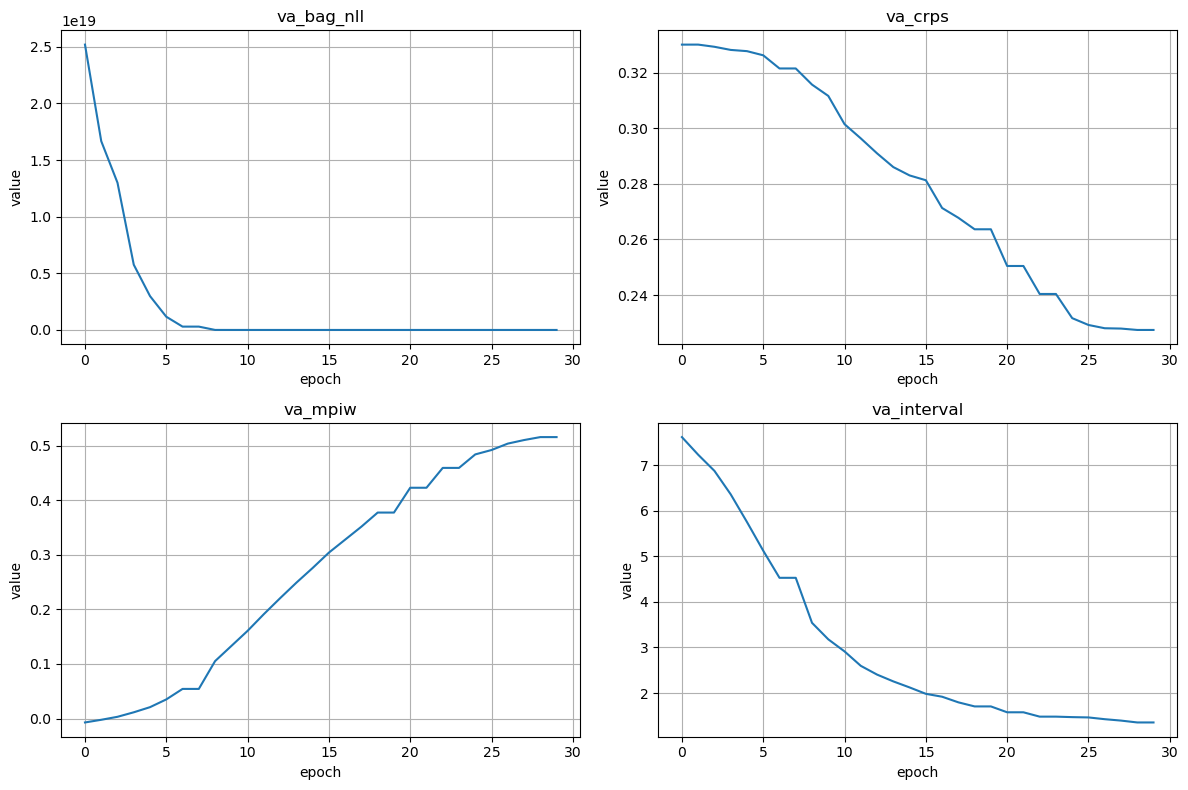

In [5]:
# Per-epoch validation diagnostics (bag_nll, crps, mpiw, interval)
va_bag = to_np(maybe_get('va_bag_nll_list'))
va_crps = to_np(maybe_get('va_crps_list'))
va_mpiw = to_np(maybe_get('va_mpiw_list'))
va_interval = to_np(maybe_get('va_interval_list'))

series = {
    'va_bag_nll': va_bag,
    'va_crps': va_crps,
    'va_mpiw': va_mpiw,
    'va_interval': va_interval,
}

if any(v is not None for v in series.values()):
    # Create a 2x2 grid of subplots, one for each metric
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    names = list(series.keys())
    for i, name in enumerate(names):
        ax = axes[i]
        arr = series[name]
        if arr is None:
            ax.text(0.5, 0.5, f'{name} missing', ha='center', va='center')
            ax.set_axis_off()
            continue
        try:
            y = np.asarray(arr)
            ax.plot(y)
            ax.set_xlabel('epoch')
            ax.set_ylabel('value')
            ax.set_title(name)
            ax.grid(True)
        except Exception:
            ax.plot(np.arange(len(arr)), arr)
            ax.set_xlabel('epoch')
            ax.set_ylabel('value')
            ax.set_title(name)
            ax.grid(True)
    # Hide any extra axes (defensive)
    for j in range(len(names), len(axes)):
        axes[j].set_visible(False)
    plt.tight_layout()
    plt.show()
else:
    print('No per-epoch validation diagnostics (va_bag_nll_list, va_crps_list, va_mpiw_list, va_interval_list) found.')

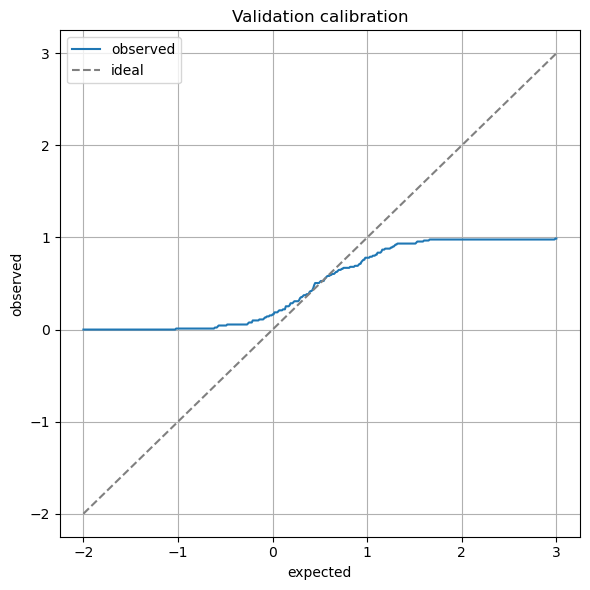

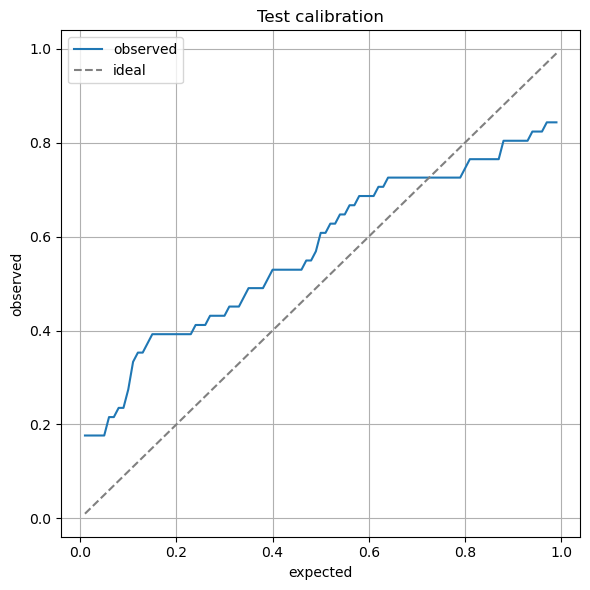

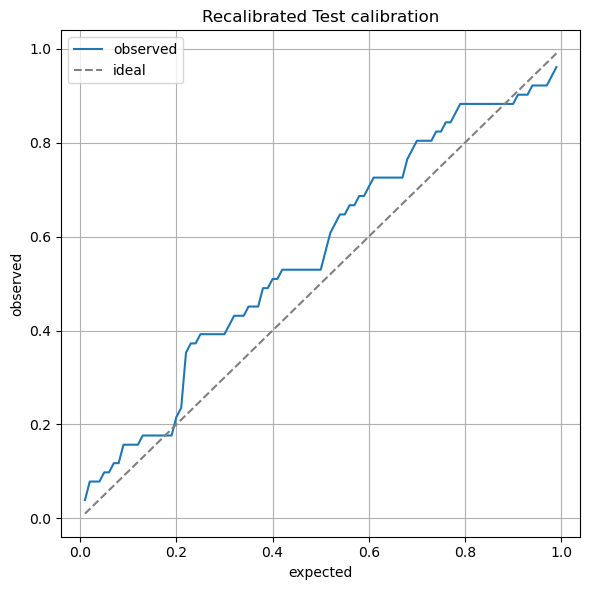

In [12]:
# Calibration curves and quantile predictions
def plot_cali(exp_props, obs_props, title='Calibration curve'):
    exp = to_np(exp_props)
    obs = to_np(obs_props)
    if exp is None or obs is None:
        print('Missing exp_props or obs_props')
        return
    plt.figure(figsize=(6,6))
    plt.plot(exp, obs, label='observed')
    plt.plot(exp, exp, '--', color='gray', label='ideal')
    plt.xlabel('expected')
    plt.ylabel('observed')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

va_exp = maybe_get('va_exp_props')
va_obs = maybe_get('va_obs_props')
if va_exp is not None and va_obs is not None:
    plot_cali(va_exp, va_obs, title='Validation calibration')
else:
    print('Validation calibration data missing')

te_exp = maybe_get('te_exp_props')
te_obs = maybe_get('te_obs_props')
if te_exp is not None and te_obs is not None:
    plot_cali(te_exp, te_obs, title='Test calibration')
else:
    print('Test calibration data missing')

recal_te_obs = maybe_get('recal_te_obs_props')
if te_exp is not None and recal_te_obs is not None:
    plot_cali(te_exp, recal_te_obs, title='Recalibrated Test calibration')
else:
    print('Recalibrated Test calibration data missing')

Comparison (test-time): original  |  best  |  recal_orig  |  recal_best
bag_nll   : orig=   13.8523 | best=   17.1635 | recal_orig=     3.04678 | recal_best=    3.65821
crps      : orig=  0.225611 | best=  0.228593 | recal_orig=    0.177361 | recal_best=   0.178181
mpiw      : orig=  0.506802 | best=  0.475739 | recal_orig=      1.4626 | recal_best=    1.28889
interval  : orig=   2.57188 | best=   2.67037 | recal_orig=     1.24747 | recal_best=   0.192705


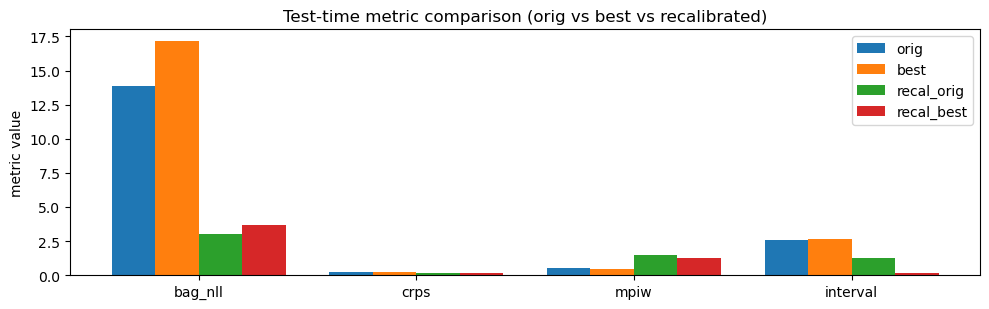


Comparison complete.


In [8]:
# Compare original final model vs best model vs recalibrated versions (if available)
def get_test_metrics_final(results):
    # Prefer structured nested dict if present
    tm = results.get('test_metrics')
    if isinstance(tm, dict) and 'te' in tm:
        return tm['te']
    # Fallback to top-level scalar entries
    fallback = {}
    for k in ['te_bag_nll','te_crps','te_mpiw','te_interval']:
        if k in results:
            fallback[k.replace('te_','')] = results[k]
    return fallback

def get_best_metrics(results):
    bm = results.get('best_model_metrics')
    if isinstance(bm, dict) and 'te' in bm:
        return bm['te']
    # fallback to top-level *_best keys
    fallback = {}
    for k in ['te_bag_nll_best','te_crps_best','te_mpiw_best','te_interval_best']:
        if k in results:
            fallback[k.replace('te_','').replace('_best','')] = results[k]
    return fallback

def get_recal_final(results):
    rf = results.get('recal_final_metrics')
    if isinstance(rf, dict) and 'te' in rf:
        return rf['te']
    return {}

def get_recal_best(results):
    rb = results.get('recal_best_metrics')
    if isinstance(rb, dict) and 'te' in rb:
        return rb['te']
    return {}

orig = get_test_metrics_final(results) or {}
best = get_best_metrics(results) or {}
recal_orig = get_recal_final(results) or {}
recal_best = get_recal_best(results) or {}

metrics = ['bag_nll','crps','mpiw','interval']

print('Comparison (test-time): original  |  best  |  recal_orig  |  recal_best')
for m in metrics:
    o = orig.get(m)
    b = best.get(m)
    ro = recal_orig.get(m)
    rb = recal_best.get(m)
    print(f"{m:10}: ", end='')
    def fmt(x):
        try:
            return f"{float(x):.6g}"
        except Exception:
            return str(x) if x is not None else 'MISSING'
    print(f"orig={fmt(o):>10} | best={fmt(b):>10} | recal_orig={fmt(ro):>12} | recal_best={fmt(rb):>11}")

# Bar plot for available metrics
available = []
labels = []
values = []
for m in metrics:
    o = orig.get(m); b = best.get(m); ro = recal_orig.get(m); rb = recal_best.get(m)
    if any(v is not None for v in [o,b,ro,rb]):
        labels.append(m)
        values.append([o if o is not None else np.nan, b if b is not None else np.nan, ro if ro is not None else np.nan, rb if rb is not None else np.nan])

if values:
    arr = np.array(values, dtype=float)
    n = arr.shape[0]
    ind = np.arange(n)
    width = 0.2
    plt.figure(figsize=(10, max(3, n*0.8)))
    plt.bar(ind - 1.5*width, arr[:,0], width, label='orig')
    plt.bar(ind - 0.5*width, arr[:,1], width, label='best')
    plt.bar(ind + 0.5*width, arr[:,2], width, label='recal_orig')
    plt.bar(ind + 1.5*width, arr[:,3], width, label='recal_best')
    plt.xticks(ind, labels)
    plt.ylabel('metric value')
    plt.legend()
    plt.title('Test-time metric comparison (orig vs best vs recalibrated)')
    plt.tight_layout()
    plt.show()
else:
    print('No comparable test-time metrics found to plot.')

print('\nComparison complete.')